# Using HyperSpy to calculate self absorption plots

This notebook demonstrates how to use HyperSpy to create "critical specimen thickness by self absorption" plots.

The calculation is simply based on Beer-Lamberts-law:

$$
I = I_0 \exp{ \left( - \left[ \mu/\rho \right] * \rho t \right) }
$$

For the calculation, the expression is rearranged to:

$$
t = - \frac{\log(I/I_0)}{\left[ \mu/\rho \right] * \rho}
$$

The absorption constant $\left[ \mu/\rho \right]$ of the `Ga_Ka` line in pure `Ga` is given by the constant found by `hs.material.mass_absorption_coefficient('Ga', 'Ga_Ka')`.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import hyperspy.api as hs

In [2]:
def create_absorption_data(family, absorption):
    
    element_dictionary = hs.material.elements.as_dictionary()
    elements = sorted(list(element_dictionary.keys()), key=lambda x: element_dictionary[x]['General_properties']['Z'])

    x = []
    y = []
    energies = []

    for el in elements:
        try:
            rho = hs.material.elements[el].Physical_properties.density_gcm3
            abs_coeff = hs.material.mass_absorption_coefficient(el, el + '_' + family + 'a')
            t = - np.log(1-absorption) / (rho * abs_coeff)
            t = t * (1e-2) * 1e9    # From cm to m, and then to nm
            x.append(hs.material.elements[el].General_properties.Z)
            y.append(t)
            energies.append(hs.material.elements[el].Atomic_properties.Xray_lines[family + 'a'].energy_keV)
        except:
            pass
    
    return {'atomic_number': x, 'critical_thickness': y, 'energies': energies}

def plot_absorption_data(families, absorption=0.05, guideline=30, kev_limit=20):
    for i, family in enumerate(families):
        data = create_absorption_data(family, absorption)
        i_lim = np.argmax( np.array(data['energies']) > kev_limit )
        if i_lim == 0: i_lim = -1
        plt.plot(data['atomic_number'][:i_lim], data['critical_thickness'][:i_lim], '.-', color='C'+str(i), label=family + ' lines')
        if i_lim != -1:
            plt.plot(data['atomic_number'][i_lim-1:-1], data['critical_thickness'][i_lim-1:-1], '.-', color='C'+str(i), alpha=0.2)
    plt.axhline(y=guideline, linestyle='--', color='grey', label=str(guideline)+' nm')
    plt.gca().set_yscale('log')
    plt.xlabel('Atomic number')
    plt.ylabel('Specimen thickness at ' + str(absorption*100) + ' %\nX-ray absorption (nm)')
    plt.ylim(10e-1, 10e8)
    plt.legend()
    plt.tight_layout()

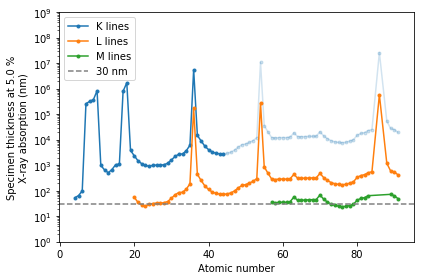

In [3]:
plot_absorption_data(['K', 'L', 'M'], absorption=0.05, guideline=30, kev_limit=20)

For reference, here is the plot by [Watanabe et. al (2006)](https://onlinelibrary.wiley.com/doi/full/10.1111/j.1365-2818.2006.01549.x). Note that there are some large deviations.

![image.png](attachments/critical_specimen_thickness_williams2006.png)